### Importing Important Libraries and files

In [1]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time

### Reading dataset path from the file system

In [2]:
paths="Dataset/"
def GetImages(train, path=paths):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

### Reading images from the given path (i.e train and test images )

In [3]:
def ImageReader(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

### Extracting SIFT features from an image

In [4]:
def SiftDescriptors(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, descriptors = sift.detectAndCompute(img, None)
    return descriptors

### Stacking the discriptors in a row vector  

In [5]:
def DescriptorVstacking(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

### Clustering the given row vector discriptors using KMeans clustering (Disriptor quantization)

In [6]:
def DescriptorsClustering(descriptors,no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans


### Extracting features from the sicriptors list and clustering the features using number of clusters 

In [7]:
def FeatureExtracter(kmeans,descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features

### Ploting the Histogram of Bag of visual words from the features clusterd using tf-idf 

In [8]:
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Visual Words Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

### Ploting confuaion matrix of a classifier

In [9]:
def PlotConfusionMatrix(true, predictions):
    np.set_printoptions(precision=2)
    classes = ["brain", "butterfly","car_side","city","dollar_bill","flamingo","headphone","laptop","wild_cat","wrench"]
    title='Confusion matrix'
    cmap=plt.cm.Blues
    cm = confusion_matrix(true,predictions)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fmt ='d' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j],fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()    
    plt.show()

### The function used to calculate the accuracy of the classifier model

In [10]:
def CoomputeAccuracy(actual, predicted):
    correct_predict = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
              correct_predict += 1
    return correct_predict/float(len(actual)) * 100.0

### Training the model using the trainnig images

In [11]:
def ModelTrain(path, no_clusters):
    training_images=path
    images = GetImages(training_images, path)
    print("Train images path detected.")
    descriptor_list = []
    train_labels = np.array([])
    label_count = 3
    image_count = len(images)
    for img_path in images:
        if("brain" in img_path):
            class_index=0
        elif("butterfly" in img_path):
            class_index=1
        elif("car_side" in img_path):
            class_index=2
        elif("city" in img_path):
            class_index=3
        elif("dollar_bill" in img_path):
            class_index=4
        elif("flamingo" in img_path):
            class_index=5
        elif("headphone" in img_path):
            class_index=6
        elif("laptop" in img_path):
            class_index=7
        elif("wild_cat" in img_path):
            class_index=8
        else:
            class_index=9
        train_labels = np.append(train_labels,class_index)
        img = ImageReader(img_path)
        des = SiftDescriptors(img)
        descriptor_list.append(des)

    descriptors = DescriptorVstacking(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = DescriptorsClustering(descriptors,no_clusters)
    print("Descriptors clustered using K-means.")

    im_features = FeatureExtracter(kmeans,descriptor_list,image_count, no_clusters)
    print("Images features extracted using SIFT.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Features Histogram for the given clusters.")
    plotHistogram(im_features, no_clusters)
    
    return kmeans, scale, im_features,train_labels

### Testing the model and predict its claddification and calculating the acuracy 

In [12]:
def ModelTest(path, kmeans,scale, knn, im_features, no_clusters):
    test_images = GetImages(False, path)
    print("Test images path detected.")
    count = 0
    true = []
    descriptor_list = []
    for img_path in test_images:
        img = ImageReader(img_path)
        des = SiftDescriptors(img)
        if(des is not None):
            count += 1
            descriptor_list.append(des)
            if("brain" in img_path):
                true.append(0)
            elif("butterfly" in img_path):
                true.append(1)
            elif("car_side" in img_path):
                true.append(2)
            elif("city" in img_path):
                true.append(3)
            elif("dollar_bill" in img_path):
                true.append(4)
            elif("flamingo" in img_path):
                true.append(5)
            elif("headphone" in img_path):
                true.append(6)
            elif("laptop" in img_path):
                true.append(7)
            elif("wild_cat" in img_path):
                true.append(8)
            else:
                true.append(9)

    descriptors = DescriptorVstacking(descriptor_list)
    test_features = FeatureExtracter(kmeans, descriptor_list, count, no_clusters)
    test_features = scale.transform(test_features)
#     print(len(test_features))
    kernel_test = test_features
    knn.predict(test_features)
    predictions = knn.predict(test_features)
    PlotConfusionMatrix(true, predictions)
#     print("Confusion matrixes plotted.")
    print ('Accuracy score: %0.3f' % CoomputeAccuracy(true, predictions))

# Testing the classifier model using the trainig images


Training the K-NN Model using k-fold cross validation to find optimal k value....
Train images path detected.
Descriptors vstacked.
Descriptors clustered using K-means.
Images features extracted using SIFT.
Features Histogram for the given clusters.


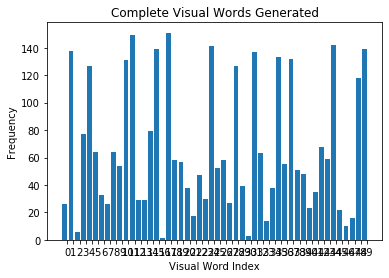

Accuracy for fold 1 [0.58139535 0.48062016 0.41860465 0.5703125  0.4921875 ]
Accuracy for fold 2 [0.54263566 0.48837209 0.44186047 0.53125    0.4453125 ]
Accuracy for fold 3 [0.56589147 0.54263566 0.48837209 0.578125   0.5390625 ]
Accuracy for fold 4 [0.62015504 0.53488372 0.46511628 0.5703125  0.5390625 ]
Accuracy for fold 5 [0.58914729 0.52713178 0.49612403 0.578125   0.5546875 ]
Accuracy for fold 6 [0.59689922 0.54263566 0.48837209 0.5703125  0.546875  ]
Accuracy for fold 7 [0.59689922 0.53488372 0.48837209 0.609375   0.5       ]
Accuracy for fold 8 [0.58914729 0.54263566 0.48062016 0.59375    0.5234375 ]
Accuracy for fold 9 [0.64341085 0.51162791 0.49612403 0.5859375  0.5       ]
Accuracy for fold 10 [0.63565891 0.48837209 0.51937984 0.5546875  0.5234375 ]
Accuracy for fold 11 [0.60465116 0.49612403 0.46511628 0.5546875  0.53125   ]
Accuracy for fold 12 [0.58914729 0.50387597 0.47286822 0.546875   0.5546875 ]
Accuracy for fold 13 [0.58914729 0.52713178 0.48062016 0.53125    0.54687

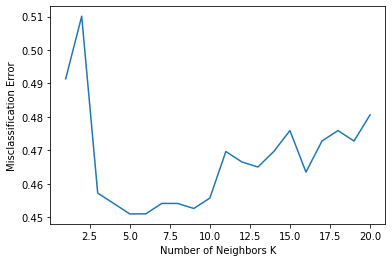

Training the K-NN Model using optimal k value....
Testing the K-NN Model Remaining 20% Test Data....
Test images path detected.


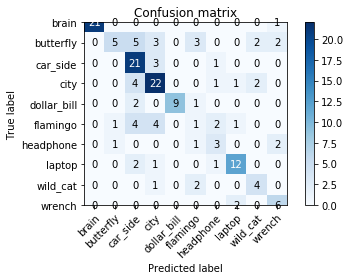

Accuracy score: 65.000
Total Time taken in Min: 4.765


In [13]:
if __name__ == '__main__':
    T_Start=time.time()
    print("\nTraining the K-NN Model using k-fold cross validation to find optimal k value....")
    train_path="Dataset/Train/"
    test_path="Dataset/Test/"
    
    no_clusters=50
    kmeans,scale,image_features,train_labels = ModelTrain(train_path, no_clusters)
    #number of neighbors to be tested to find the optimal one
    neighbors = list(range(1,21))
    # empty list that will hold cv scores
    cross_validation_scores = []
    # perform 4-fold cross validation
    for k in neighbors:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn_model, image_features, train_labels, cv=5)
        cross_validation_scores.append(scores.mean())
        print("Accuracy for fold {}".format(k),scores)
    print("\nMean Accuracy for each fold :",cross_validation_scores)
    print("\nMaximum accuracy gained in trainig using k-fold is:%.3f"%(max(cross_validation_scores)*100))
    print("\nMinimum Error gained in trainig using k-fold is:%.3f"%(1-(max(cross_validation_scores))))
    
     # changing to misclassification error
    misclassification_error = [1-x for x in cross_validation_scores]
    # determining best k
    optimal_k = neighbors[misclassification_error.index(min(misclassification_error))]
    print("\nThe optimal number of neighbors (Value of K) is {}".format(optimal_k))
    # plot misclassification error vs k
    plt.plot(neighbors, misclassification_error)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()   
    
    print("Training the K-NN Model using optimal k value....")
    knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
    knn_model.fit(image_features,train_labels)
    
    print("Testing the K-NN Model Remaining 20% Test Data....")
    ModelTest(test_path, kmeans,scale,knn_model,image_features,no_clusters)
    T_Stop=time.time()
    print("Total Time taken in Min: %.3f" %((T_Stop-T_Start)/60.0))